In [1]:
import numpy as np
from numpy.random import multivariate_normal as mvnrnd
import matplotlib.pyplot as plt

from torch.autograd.functional import jacobian
from torch import tensor
import torch

In [2]:
# from utils import ExtendedKalmanFilter as EKF

# def f_tensor(x, u):
#     y0 = torch.sin(x[0]) - u[0] * torch.cos(x[1])
#     y1 = 2 * torch.cos(x[0]) * torch.sin(x[1])
#     return (y0,y1)

# ekf = EKF(f_tensor)

In [8]:
# System Description
def f_tensor(x_tensor, u_tensor):
    y0 = torch.sin(x_tensor[0]) - u_tensor[0] * torch.cos(x_tensor[1])
    y1 = 2 * torch.cos(x_tensor[0]) * torch.sin(x_tensor[1])
    return (y0,y1)

def f(x, u):
    x_tensor = tensor(x)
    u_tensor = tensor(u)
    y0, y1 = f_tensor(x_tensor, u_tensor)
    y = np.array([[y0.item()], [y1.item()]])
    return y

def jacob(x, u):
    x_tensor = tensor(x)
    u_tensor = tensor(u)
    dy0dxdu, dy1dxdu = jacobian(f_tensor,(x_tensor, u_tensor))
    dy0dx, dy1dx = dy0dxdu[0], dy1dxdu[0]
    dy0du, dy1du = dy0dxdu[1], dy1dxdu[1]
    Jx = np.row_stack([dy0dx.numpy()[0].T, dy1dx.numpy()[0].T])
    Ju = np.row_stack([dy0du.numpy()[0].T, dy1du.numpy()[0].T])
    return Jx, Ju

In [9]:
n = 2 # state vector size
m = 1 # control size
p = 1 # output vector size
c = np.array([[-0.12, 0.06]]) # read-out matrix

T = np.arange(0, 100)  # Time points for simulation
x0 = np.array([[-3.0], [3.0]])

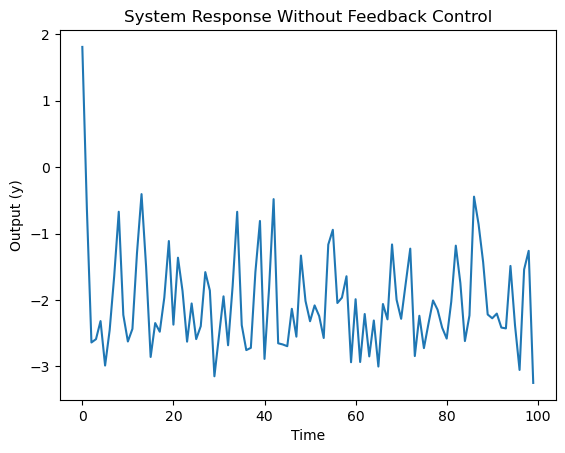

In [10]:
# Simulation Without Control
x = x0.copy()
u = np.array([[2.0]])
xs = []
ys = []

# process noise
Bnoise = np.eye(n)  # Process noise enters directly on states
W = 0.1 * np.eye(n)  # Process noise weight

for i in T:
    
    # update x
    process_noise = mvnrnd(np.zeros(n), W).reshape(-1,1)
    x1 = f(x, u) + Bnoise @ process_noise
    x = x1.copy()

    # output
    y = c @ x
    
    # save
    xs.append(x)
    ys.append(y.item())

# Plot the output 'ys'
x1s = [x[0].item() for x in xs]
# lt.plot(T, ys)
plt.plot(T, x1s)
plt.xlabel('Time')
plt.ylabel('Output (y)')
plt.title('System Response Without Feedback Control')
plt.show()

### Extended Kalman Filter

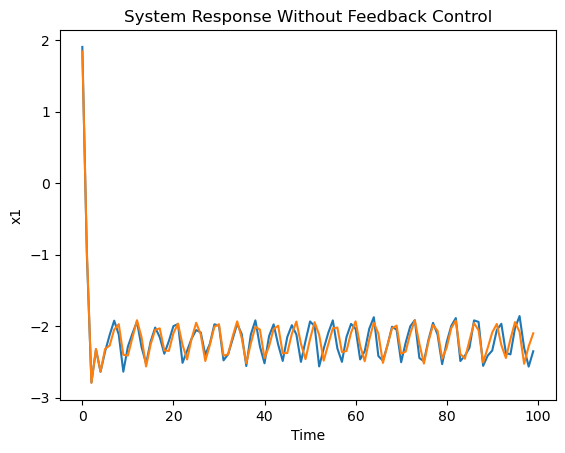

In [16]:
# Design Kalman Filter
Bnoise = np.eye(n)  # Process noise enters directly on states
W = 0.001 * np.eye(n)  # Process noise weight
V = 0.001 * np.eye(m)  # Measurement noise weight

x = x0.copy()
xhat = x0.copy()
Phat = W.copy()
u = np.array([[2.0]])
xs = []
ys = []
xhats = []
yress = []
for i in T:

    # Update x
    process_noise = mvnrnd(np.zeros(n), W).reshape(-1,1)
    x1 = f(x, u) + Bnoise @ process_noise
    x = x1.copy()

    # Output
    measurement_noise = mvnrnd(np.zeros(p), V).reshape(-1,1)
    y = c @ x + measurement_noise

    # Save
    xs.append(x)
    ys.append(y.item())

    # Kalman
    xpred = f(xhat, u)
    F, _ = jacob(xhat, u)
    Ppred = F @ Phat @ F.T + W
    ypred = c @ xpred

    S = c @ Ppred @ c.T + V
    Kf = Ppred @ c.T @ np.linalg.inv(S)

    xhat = xpred + Kf @ (y - ypred)
    phat = Ppred - Kf @ c @ Ppred
    yres = y - c @ xhat

    xhats.append(xhat)
    yress.append(yres.item())

# Plot the state
x1s = [x[0].item() for x in xs]
xhat1s = [x[0].item() for x in xhats]
# lt.plot(T, ys)
plt.plot(T, x1s)
plt.plot(T, xhat1s)
# plt.plot(T, yress)
plt.xlabel('Time')
plt.ylabel('x1')
plt.title('System Response Without Feedback Control')
plt.show()